# A Naive-Bayes classifier of spam SMSs
Using the SMS Spam collection dataset from UCI Machine Learning
https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

## Data cleaning
The csv file has a formatting issue. There are commas in the SMS description which creates artificial columns. Let's start by removing all the commas from the text description

In [2]:
'''A function that removes all but the first comma in a string'''
def rreplace(s, old, new):
    occurrence = s.count(old) -1
    li = s.rsplit(old, occurrence)
    return new.join(li)

a = 'cat word,, dog, word, mouse, word'
rreplace(a, ',', '')

'cat word, dog word mouse word'

In [3]:
f = open('spam.csv')
f_clean = open('spam_clean.csv','w')
for line in f.readlines():
    
    clean_line = rreplace(line,',','')
    f_clean.write(clean_line)
        
f_clean.close()

We can now load the clean data set. 

In [4]:
df = pd.read_csv('spam_clean.csv', encoding="latin-1")
df.info()
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})
X = df['v2']
y = df['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


## Some data exploration

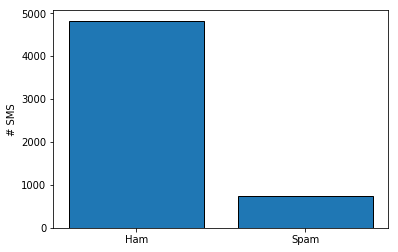

In [5]:
plt.bar([0,1],df.groupby('v1').count().v2.values, edgecolor='k')
plt.xticks([0,1], ('Ham', 'Spam'))
plt.ylabel('# SMS')
plt.show()

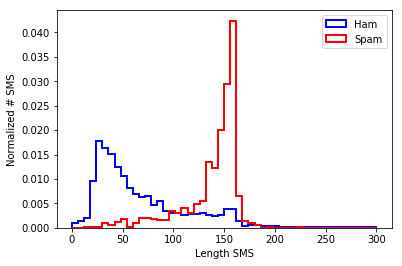

In [6]:
df['lengthSMS'] = df['v2'].apply(lambda x: len(x))
plt.hist(df.query('label==0').lengthSMS, lw=2, edgecolor='b',bins=50,
         density=True, histtype='step',label='Ham',range=[0,300])
plt.hist(df.query('label==1').lengthSMS, lw=2, edgecolor='r',bins=50,
         density=True, histtype='step',label='Spam',range=[0,300])
plt.xlabel('Length SMS')
plt.ylabel('Normalized # SMS')
plt.legend()
plt.show()

Messages above 100 characters tend to be spam. We will use sklearn's `CountVectorizer` to create a sparse matrix of token counts.

## Feature Engineering

In [7]:
## Build token matrix
cv = CountVectorizer()
X_tokens = cv.fit_transform(X)

In [8]:
cv_ham = CountVectorizer()
X_ham = cv_ham.fit_transform(X[y==0])
cv_spam = CountVectorizer()
X_spam = cv_spam.fit_transform(X[y==1])

In [9]:
sum_words = X_ham.sum(axis=0)
sum_words
words_freq = [(word, sum_words[0, idx]) for word, idx in cv_ham.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Top ham tokens:", words_freq[:10])

sum_words = X_spam.sum(axis=0)
sum_words
words_freq = [(word, sum_words[0, idx]) for word, idx in cv_spam.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Top spam tokens:", words_freq[:10])

('Top ham tokens:', [(u'you', 1942), (u'to', 1562), (u'the', 1133), (u'and', 857), (u'in', 821), (u'me', 776), (u'my', 753), (u'is', 738), (u'it', 707), (u'that', 554)])
('Top spam tokens:', [(u'to', 691), (u'call', 355), (u'you', 297), (u'your', 264), (u'free', 224), (u'the', 206), (u'for', 203), (u'now', 199), (u'or', 188), (u'txt', 163)])


## Build the model

In [10]:
## Split train/test data set
X_train, X_test, y_train, y_test = train_test_split(X_tokens, y, test_size=0.33, random_state=42)

## Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1587
          1       0.92      0.92      0.92       252

avg / total       0.98      0.98      0.98      1839



## Actually, need both steps combined, so let's build a pipeline
Also, here I will use both test and train data in the tokenization to have as many tokens included in the corpus

In [11]:
pipeline = Pipeline([
    ('feature_building',CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('feature_building', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [12]:
joblib.dump(pipeline, 'spam_pipeline.pkl')

['spam_pipeline.pkl']

In [13]:
## Test it
text_message = ['text one two three, fefref, fef','to call you your free']
spam_pipeline = open('spam_pipeline.pkl')
pipeline_load = joblib.load(spam_pipeline)
pipeline_load.predict(text_message)

array([0, 1])

## It works!